![ML Logo](http://spark-mooc.github.io/web-assets/images/CS190.1x_Banner_300.png)
# **Click-Through Rate Prediction Lab**
This lab covers the steps for creating a click-through rate (CTR) prediction pipeline.  You will work with the [Criteo Labs](http://labs.criteo.com/) dataset that was used for a recent [Kaggle competition](https://www.kaggle.com/c/criteo-display-ad-challenge).

The material structure is essentially from the online course [BerkeleyX: CS190.1x Scalable Machine Learning](https://courses.edx.org/courses/BerkeleyX/CS190.1x/1T2015/info), in which we will use Spark and MLlib to perform logistic regression. To make the note more concise, however, I cut some contents such as tutorial introduction on **SparseVector**. Meanwhile, we will also examine other classifier: Naive Bayes, and compare it with the logistic regression. We find that logistic regression has slightly better performance than Naive Bayes.

#### ** This lab will cover: **
+  **Sec. 1: Featurize categorical data using one-hot-encoding (OHE)**
  + ** Sec. 1.1: One-hot-encoding**
  + ** Sec. 1.2: Define an OHE function**
+  **Sec. 2: Construct an OHE dictionary**
  + **Sec. 2.1: Pair RDD of (featureID, category) in the toy example**
  + **Sec. 2.2: OHE Dictionary from distinct features**
  + **Sec. 2.3: Automated creation of an OHE dictionary**
+  **Sec. 3: Parse CTR data and generate OHE features**
  + **Sec. 3.1: Parse data and splitting into training, validation and test sets**
  + **Sec. 3.2: Determine the number of OHE features**
  + **Sec. 3.3: Create an OHE dictionary from the dataset**
  + **Sec. 3.4: Using LabeledPoint to store label and OHE features**
  + **Sec. 3.5: Handling unseen features**
+   **Sec. 4: CTR prediction and logloss evaluation**
  + **Sec. 4.1: Logistic regression**
  + **Sec. 4.2: Define Log loss**
  + **Sec. 4.3: Log loss for the baseline model**
  + **Sec. 4.4: Predicted probability**
  + **Sec. 4.5: Evaluate the model**
  + **Sec. 4.6: Validation log loss**
  + **Sec. 4.7: Grid Search**
  + **Sec. 4.8: ROC curve**
+   **Sec. 5: Reduce feature dimension via feature hashing**
  + **Sec. 5.1: Hash function **
  + **Sec. 5.2: Sparsity**
  + **Sec. 5.3: Logistic model with hashed features **
  + **Sec. 5.4: Evaluate on the test set**
  + **Sec. 5.5: Performance comparison using OHE and Hash feature reps**
+   **Sec. 6: Other Classifiers**
  + **Sec. 6.1: Naive Bayes Classifier**
  + **Sec. 6.2: Decision Trees model (not working)**
 
Note that, for reference, you can look up the details of the relevant Spark methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

In [1]:
labVersion = 'cs190_week4_v_1_3'

## **The Data**

In [2]:
import numpy as np
import pandas as pd

data = pd.read_table('dac_sample.txt', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0,1,1,5,0,1382,4,15,2,181,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,NaN,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2,0,44,1,102,8,2,2,4,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,NaN,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2,0,1,14,767,89,4,2,245,...,8efede7f,3412118d,NaN,NaN,e587c466,ad3062eb,3a171ecb,3b183c5c,NaN,NaN
3,0,NaN,893,NaN,NaN,4392,NaN,0,0,0,...,1e88c74f,74ef3502,NaN,NaN,6b3a5ca6,NaN,3a171ecb,9117a34a,NaN,NaN
4,0,3,-1,NaN,0,2,0,3,0,0,...,1e88c74f,26b3c7a7,NaN,NaN,21c9516a,NaN,32c7478e,b34f3128,NaN,NaN


In [3]:
data.shape

(100000, 40)

## ** Part 1: Featurize categorical data using one-hot-encoding **

### ** Sec. 1.1: One-hot-encoding **
We would like to develop code to convert categorical features to numerical ones, and to build intuition, we will work with a sample unlabeled dataset with three data points, with each data point representing an animal. The first feature indicates the type of animal (bear, cat, mouse); the second feature describes the animal's color (black, tabby); and the third (optional) feature describes what the animal eats (mouse, salmon).

In a one-hot-encoding (OHE) scheme, we want to represent each tuple of `(featureID, category)` via its own binary feature.  We can do this in Python by creating a dictionary that maps each tuple to a distinct integer, where the integer corresponds to a binary feature. To start, manually enter the entries in the OHE dictionary associated with the sample dataset by mapping the tuples to consecutive integers starting from zero,  ordering the tuples first by featureID and next by category.

Later in this lab, we'll use OHE dictionaries to transform data points into compact lists of features that can be used in machine learning algorithms.

#### ** (1.1a) OHE for a toy example**

Suppose now we have a toy dataset. There are three observations: sampleOne, sampleTwo and sampleThree. Each one then has three features: '0' denotes 'animal type', '1' 'color pattern', '2' 'food the animal eats', as follows. We prepare it as a RDD:

In [2]:
# Data for manual OHE
# Note: the first data point does not include any value for the optional third feature
sampleOne = [(0, 'mouse'), (1, 'black')]
sampleTwo = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
sampleThree =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]
sampleDataRDD = sc.parallelize([sampleOne, sampleTwo, sampleThree])
print type(sampleDataRDD)

<class 'pyspark.rdd.RDD'>


In [5]:
sampleOHEDictManual = {}
sampleOHEDictManual[(0,'bear')] = 0
sampleOHEDictManual[(0,'cat')] =  1
sampleOHEDictManual[(0,'mouse')] = 2
sampleOHEDictManual[(1, 'black')] = 3
sampleOHEDictManual[(1, 'tabby')] = 4
sampleOHEDictManual[(2, 'mouse')] = 5
sampleOHEDictManual[(2, 'salmon')] = 6

In [6]:
print sampleOHEDictManual

{(2, 'mouse'): 5, (0, 'cat'): 1, (0, 'bear'): 0, (2, 'salmon'): 6, (1, 'tabby'): 4, (1, 'black'): 3, (0, 'mouse'): 2}


In the **DenseVector rep**, the features of the toy example can be denoted as (featuredID, category). Like:
+ (0, 'bear') = [1,0,0,0,0,0,0]
+ (0, 'cat') = [0,1,0,0,0,0,0]  
+ (0, 'mouse') = [0,0,1,0,...]   ....
+ (2, 'salmon') = [0,0,.....0,1]

Therefore the OHE features of these observations are represented as 
+ **sampleOne = [(0, 'mouse'), (1, 'black')]= [0,0,1,1,0,0,0,0]**
+ **sampleTwo = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')] = [0,1,0,0,1,1,0]**
+ **sampleThree = [(0, 'bear'), (1, 'black'), (2, 'salmon')] = [1,0,0,1,0,0,1]**

In other words, this converts to **sampleOne: x=(x2=1,x3=1; others=0)**; **sampleTwo: x=(x1=1, x4=1, x5=1; others=0)**; **sampleThree: x=(x0=1, x3=1, x6=1; others=0)**. The OEH feature vector x is 7-dimensional.

#### ** (1.1b) Sparse vector representation **
Data points can typically be represented with a small number of non-zero OHE features relative to the total number of features that occur in the dataset.  By leveraging this sparsity and using sparse vector representations of OHE data, we can reduce storage and computational burdens.  Below are a few sample vectors represented as dense numpy arrays.  Use [SparseVector](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.SparseVector) to represent them in a sparse fashion, and verify that both the sparse and dense representations yield the same results when computing [dot products](http://en.wikipedia.org/wiki/Dot_product) (we will later use MLlib to train classifiers via gradient descent, and MLlib will need to compute dot products between SparseVectors and dense parameter vectors).

Use `SparseVector(size, *args)` to create a new sparse vector where size is the length of the vector and args is either a dictionary, a list of (index, value) pairs, or two separate arrays of indices and values (sorted by index).  You'll need to create a sparse vector representation of each dense vector `aDense` and `bDense`.

In [7]:
import numpy as np
from pyspark.mllib.linalg import SparseVector

With the **SparseVector** rep, the vectors can have addition, minus, dot product operation with normal vectors etc:

In [8]:
a = SparseVector(4, [1, 3], [3.0, 4.0])  ## a= [0,3,0,4]
print a
b = SparseVector(4, [2], [1.0])          ## b= [0,0,1,0]
print b
print a.dot(b)

(4,[1,3],[3.0,4.0])
(4,[2],[1.0])
0.0


In [9]:
# TODO: Replace <FILL IN> with appropriate code
aDense = np.array([0., 3., 0., 4.])
aSparse = SparseVector(4, [1,3], [3.,4.])

w = np.array([0.4, 3.1, -1.4, -.5])
print aDense.dot(w)
print aSparse.dot(w)

7.3
7.3


#### **(1.1c) Using sparse vectors to represent OHE features**
Now let's see how we can represent the OHE features for points in our sample dataset.  Using the mapping defined by the OHE dictionary from Part (1a), manually define OHE features for the three sample data points using SparseVector format.  Any feature that occurs in a point should have the value 1.0.  For example, the `DenseVector` for a point with features 2 and 4 would be `[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]`.

Reminder of the sample features:
+ **sampleOne = [(0, 'mouse'), (1, 'black')]**
+ **sampleTwo = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]**
+ **sampleThree =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]**

and we have a dictionary **sampleOHEDictManual = {(0, 'bear'):0, (0, 'cat'):1, (0, 'mouse'):2, (1, 'black'):3, (1, 'tabby'):4, (2, 'mouse'):5, (2, 'salmon'):6}** to label the OHE feature. In the **Sparse vector** rep, they can be writtne as

In [10]:
sampleOneOHEFeatManual = SparseVector(7,[2,3],[1.,1.])
sampleTwoOHEFeatManual = SparseVector(7,[1,4,5],[1.,1.,1.])
sampleThreeOHEFeatManual = SparseVector(7,[0,3,6],[1.,1.,1.])

### ** Sec. 1.2: Define an OHE function **
Next we will use the OHE dictionary from (1.1a) to programatically generate OHE features from the original categorical data.  First write a function called `oneHotEncoding` that creates OHE feature vectors in `SparseVector` format.  Then use this function to create OHE features for the first sample data point and verify that the result matches the result from (1.1c).

In [12]:
def oneHotEncoding(rawFeats, OHEDict, numOHEFeats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.
    Note:
        You should ensure that the indices used to create a SparseVector are sorted.
    Args:
        rawFeats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sampleOne)
        OHEDict (dict): A mapping of (featureID, value) to unique integer.
        numOHEFeats (int): The total number of unique OHE features (combinations of featureID and
            value).
    Returns:
        SparseVector: A SparseVector of length numOHEFeats with indicies equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    positionIndex = []
    for features in rawFeats:
        positionIndex.append(OHEDict[features])
    value = [1.0]*len(positionIndex)
    return SparseVector(numOHEFeats, sorted(positionIndex), value)

We will use the `oneHotEncoding` function to create OHE features for all 3 data points in the toy sample dataset RDD:

In [19]:
sampleOHEData = sampleDataRDD.map(lambda x: oneHotEncoding(x, sampleOHEDictManual, len(sampleOHEDictManual)))
print sampleOHEData.collect()

[SparseVector(7, {2: 1.0, 3: 1.0}), SparseVector(7, {1: 1.0, 4: 1.0, 5: 1.0}), SparseVector(7, {0: 1.0, 3: 1.0, 6: 1.0})]


## ** Part 2: Construct an OHE dictionary **

### ** Sec. 2.1: Pair RDD of `(featureID, category)` in the toy example**
Here, we will mention how to preare the OHE dictionary. To start, create an RDD of distinct `(featureID, category)` tuples. In our sample dataset, the 7 items in the resulting RDD are `(0, 'bear')`, `(0, 'cat')`, `(0, 'mouse')`, `(1, 'black')`, `(1, 'tabby')`, `(2, 'mouse')`, `(2, 'salmon')`. Notably `'black'` appears twice in the dataset but only contributes one item to the RDD: `(1, 'black')`, while `'mouse'` also appears twice and contributes two items: `(0, 'mouse')` and `(2, 'mouse')`.  Use [flatMap](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.flatMap) and [distinct](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.distinct).

Note that after reading data from text file, the toy sample RDD shows as

In [17]:
print sampleDataRDD.take(3)

[[(0, 'mouse'), (1, 'black')], [(0, 'cat'), (1, 'tabby'), (2, 'mouse')], [(0, 'bear'), (1, 'black'), (2, 'salmon')]]


We need to use `flatMap` to smear the "barrier" between the samples and `distinct()` to make the elements in the list unique:

In [22]:
sampleDistinctFeats = sampleDataRDD.flatMap(lambda x: x).distinct()

In [24]:
print sampleDistinctFeats.take(10)

[(2, 'mouse'), (0, 'cat'), (0, 'bear'), (2, 'salmon'), (1, 'tabby'), (1, 'black'), (0, 'mouse')]


Now we can see all OHE features are in a list. This can help us to construct the OHE feature dictionary in the dataset.

### ** Sec. 2.2: OHE Dictionary from distinct features **

The above shows using `flatMap` to generate the OHE feature dictionary. But we need a more systematic way to generate the OHE feature dictionary.

Here are procedures. First create an `RDD` of key-value tuples, where each `(featureID, category)` tuple in `sampleDistinctFeats` is a key and the values are distinct integers ranging from 0 to (number of keys - 1).  Then convert this `RDD` into a dictionary, which can be done using the `collectAsMap` action.  Note that there is no unique mapping from keys to values, as all we require is that each `(featureID, category)` key be mapped to a unique integer between 0 and the number of keys.  In this exercise, any valid mapping is acceptable.  Use [zipWithIndex](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.zipWithIndex) followed by [collectAsMap](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.collectAsMap).

In our sample dataset, one valid list of key-value tuples is: `[((0, 'bear'), 0), ((2, 'salmon'), 1), ((1, 'tabby'), 2), ((2, 'mouse'), 3), ((0, 'mouse'), 4), ((0, 'cat'), 5), ((1, 'black'), 6)]`. The dictionary **sampleOHEDictManual** defined in Sec.(1.1a) illustrates another valid mapping between keys and integers.

We first use `zipWithIndex()` to designate the index:

In [28]:
sampleOHEDict = (sampleDistinctFeats.zipWithIndex())
print sampleOHEDict.take(7)

[((2, 'mouse'), 0), ((0, 'cat'), 1), ((0, 'bear'), 2), ((2, 'salmon'), 3), ((1, 'tabby'), 4), ((1, 'black'), 5), ((0, 'mouse'), 6)]


Next we use `collectAsMap()` to collect and also convert to a dictionary

In [30]:
sampleOHEDict = (sampleDistinctFeats.zipWithIndex().collectAsMap())
print type(sampleOHEDict), sampleOHEDict

<type 'dict'> {(2, 'mouse'): 0, (0, 'cat'): 1, (0, 'bear'): 2, (2, 'salmon'): 3, (1, 'tabby'): 4, (1, 'black'): 5, (0, 'mouse'): 6}


Now the keys are

In [31]:
 print type(sampleOHEDict.keys()), sampleOHEDict.keys()

<type 'list'> [(2, 'mouse'), (0, 'cat'), (0, 'bear'), (2, 'salmon'), (1, 'tabby'), (1, 'black'), (0, 'mouse')]


### **Sec. 2.3: Automated creation of an OHE dictionary **
Now we can combine the procedures from Sec. 2.1 and 2.2 to write a systematic function that takes an input dataset and outputs an OHE dictionary. Usually the amount of data is intractable. Then use this function to create an OHE dictionary for the sample dataset, and verify that it matches the dictionary from Sec. 2.2.

In [33]:
def createOneHotDict(inputData):
    """Creates a one-hot-encoder dictionary based on the input data.
    Args:
        inputData (RDD of lists of (int, str)): An RDD of observations where each observation is
            made up of a list of (featureID, value) tuples.
    Returns:
        dict: A dictionary where the keys are (featureID, value) tuples and map to values that are
            unique integers.
    """
    return inputData.flatMap(lambda x: x).distinct().zipWithIndex().collectAsMap()

Let us use the `createOneHotDict` function to test our toy example:

In [34]:
sampleOHEDictAuto = createOneHotDict(sampleDataRDD)
print sampleOHEDictAuto

{(2, 'mouse'): 0, (0, 'cat'): 1, (0, 'bear'): 2, (2, 'salmon'): 3, (1, 'tabby'): 4, (1, 'black'): 5, (0, 'mouse'): 6}


## **Sec. 3: Parse CTR data and generate OHE features**

Before we can proceed, you'll first need to obtain the data from Criteo.  If you have already completed this step in the setup lab, just run the cells below and the data will be loaded into the `rawData` RDD variable.

Below is Criteo's data sharing agreement.  After you accept the agreement, you can obtain the download URL by right-clicking on the "Download Sample" button and clicking "Copy link address" or "Copy Link Location", depending on your browser.  Paste the URL into the `# TODO` cell below.  The file is 8.4 MB compressed.  The script below will download the file to the virtual machine (VM) and then extract the data. Open the [Criteo agreement](http://labs.criteo.com/downloads/2014-kaggle-display-advertising-challenge-dataset/) in a separate browser tab.  After you accept the agreement, you can obtain the download URL by right-clicking on the "Download Sample" button and clicking "Copy link address" or "Copy Link Location", depending on your browser.

Note that the download could take a few minutes, depending upon your connection speed. The following is that I assume we have downloaded the data and store in the folder. There are 100000 observations.

In [36]:
rawData = (sc.textFile('data/cs190/dac_sample.txt', 2)
               .map(lambda x: x.replace('\t', ',')))  # work with either ',' or '\t' separated data
print rawData.take(2)
print rawData.count()

[u'0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16', u'0,2,0,44,1,102,8,2,2,4,1,1,,4,68fd1e64,f0cf0024,6f67f7e5,41274cd7,25c83c98,fe6b92e5,922afcc0,0b153874,a73ee510,2b53e5fb,4f1b46f3,623049e6,d7020589,b28479f6,e6c5b5cd,c92f3b61,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,,3a171ecb,43f13e8b,e8b83407,731c3655']
100000


### ** Sec. 3.1: Parse data and splitting into training, validation and test sets **
We are now ready to start working with the actual CTR data, and our first task involves splitting it into training, validation, and test sets.  Use the [randomSplit method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.randomSplit) with the specified weights and seed to create RDDs storing each of these datasets, and then [cache](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.cache) each of these RDDs, as we will be accessing them multiple times in the remainder of this lab. Finally, compute the size of each dataset.

In [38]:
weights = [.8, .1, .1]
seed = 42
# Use randomSplit with weights and seed
rawTrainData, rawValidationData, rawTestData = rawData.randomSplit(weights, seed)
# Cache the data
rawTrainData.cache()
rawValidationData.cache()
rawTestData.cache()

nTrain = rawTrainData.count()
nVal = rawValidationData.count()
nTest = rawTestData.count()
print nTrain, nVal, nTest, nTrain + nVal + nTest

79911 10075 10014 100000


### ** Sec. 3.2: Determine the number of OHE features**
We will now parse the raw training data to create an RDD that we can subsequently use to create an OHE dictionary. Note from the `rawData.take()` command shows that each raw data point is a string containing several fields separated by some delimiter.  For now, we will ignore the first field (which is the 0/1 label), and parse the remaining fields (or raw features).  To do this, complete the implemention of the `parsePoint` function.

In [40]:
def parsePoint(point):
    """Converts a comma separated string into a list of (featureID, value) tuples.
    Note:
        featureIDs should start at 0 and increase to the number of features - 1.
    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.
    Returns:
        list: A list of (featureID, value) tuples.
    """
    point = point.split(',')
    return [(i, point) for i, point in enumerate(point[1:])]

In [42]:
print rawTrainData.take(2)

[u'0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16', u'0,2,0,44,1,102,8,2,2,4,1,1,,4,68fd1e64,f0cf0024,6f67f7e5,41274cd7,25c83c98,fe6b92e5,922afcc0,0b153874,a73ee510,2b53e5fb,4f1b46f3,623049e6,d7020589,b28479f6,e6c5b5cd,c92f3b61,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,,3a171ecb,43f13e8b,e8b83407,731c3655']


After using  `parsePoint` function:

In [43]:
parsedTrainFeat = rawTrainData.map(lambda x: parsePoint(x))
print parsedTrainFeat.take(2)

[[(0, u'1'), (1, u'1'), (2, u'5'), (3, u'0'), (4, u'1382'), (5, u'4'), (6, u'15'), (7, u'2'), (8, u'181'), (9, u'1'), (10, u'2'), (11, u''), (12, u'2'), (13, u'68fd1e64'), (14, u'80e26c9b'), (15, u'fb936136'), (16, u'7b4723c4'), (17, u'25c83c98'), (18, u'7e0ccccf'), (19, u'de7995b8'), (20, u'1f89b562'), (21, u'a73ee510'), (22, u'a8cd5504'), (23, u'b2cb9c98'), (24, u'37c9c164'), (25, u'2824a5f6'), (26, u'1adce6ef'), (27, u'8ba8b39a'), (28, u'891b62e7'), (29, u'e5ba7672'), (30, u'f54016b9'), (31, u'21ddcdc9'), (32, u'b1252a9d'), (33, u'07b5194c'), (34, u''), (35, u'3a171ecb'), (36, u'c5c50484'), (37, u'e8b83407'), (38, u'9727dd16')], [(0, u'2'), (1, u'0'), (2, u'44'), (3, u'1'), (4, u'102'), (5, u'8'), (6, u'2'), (7, u'2'), (8, u'4'), (9, u'1'), (10, u'1'), (11, u''), (12, u'4'), (13, u'68fd1e64'), (14, u'f0cf0024'), (15, u'6f67f7e5'), (16, u'41274cd7'), (17, u'25c83c98'), (18, u'fe6b92e5'), (19, u'922afcc0'), (20, u'0b153874'), (21, u'a73ee510'), (22, u'2b53e5fb'), (23, u'4f1b46f3'), (2

Each element is parsed as (featureID, categories). The featureID = 0,1,..38, and different featureID can have different categories. To count the number of OHE fetures, we should identify how many unique characters in each features:

In [44]:
numCategories = parsedTrainFeat.flatMap(lambda x: x).distinct() \
                 .map(lambda x: (x[0], 1)).reduceByKey(lambda x, y: x + y).sortByKey().collect()

In [45]:
print numCategories

[(0, 144), (1, 2467), (2, 855), (3, 129), (4, 20311), (5, 1890), (6, 567), (7, 142), (8, 1796), (9, 8), (10, 81), (11, 62), (12, 252), (13, 471), (14, 492), (15, 36044), (16, 21331), (17, 131), (18, 12), (19, 7221), (20, 233), (21, 3), (22, 9905), (23, 3678), (24, 33988), (25, 2741), (26, 25), (27, 4844), (28, 28762), (29, 10), (30, 2379), (31, 1223), (32, 4), (33, 31887), (34, 11), (35, 14), (36, 10799), (37, 49), (38, 8325)]


This shows featureID =0, there are 144 distinct categories, featureID=1, there are 2467..

In [47]:
print numCategories[0][1], numCategories[1][1], numCategories[2][1]

144 2467 855


There are 38 features for each observaiton. Like the sample example, the featureID = 0, labeling 'anamial', there are 3 different descriptions: 'mouse', 'cat', and 'bear'; for featureID=1, labeling 'color', two: 'black' and 'tabby'; for eatureID = 2, labeling 'food', two: 'mouse' and 'salmon'. Then we will know the total size of sparse vector to generate should be 3+2+2=7. In our dataset, we should have 144+2467+...+8325 =233286, which gives the number of OHE features and determine the size of the sparse vectors.

In [51]:
totalSize =0
for i in range(len(numCategories)):
    totalSize += numCategories[i][1]
print totalSize    

233286


### **Sec. 3.3: Create an OHE dictionary from the dataset **
Note that parsePoint returns a data point as a list of `(featureID, category)` tuples, which is the same format as the sample dataset studied in Sec. 1 and 2 of this lab.  Using this observation, create an OHE dictionary using the function implemented in Sec. 2.3. Note that we will assume for simplicity that all features in our CTR dataset are categorical.

In [54]:
ctrOHEDict = createOneHotDict(parsedTrainFeat)
numCtrOHEFeats = len(ctrOHEDict.keys())
'''ctrOHEDict is the size of indices in the sparse Vector, i.e. there will be 233286 distinct OHE features.
   In other words, in the DenseVector rep, it will be [0,0,1,0,0,...1,0....1]; each vector has 233286 components'''
print numCtrOHEFeats

233286


The size of the sparse vector to denote our OEH features is 233286. 

ctrOHEDict[(1,'a')] is the position index of the key=(1,'a') at featureID=1, and 'a' category.
e.g. the key (28, u'afc930ae') is at 0-th spot, i.e. in the DenseVector rep it is [1,0,0...];
the key (16, u'0e4666ea') is at 116918-th spot; it is [0,0...,0,1,0,0...0], where 1 is at 116918-th spot.

In [55]:
i=0
for ch in ctrOHEDict:
    i += 1
    if i <=5: print i, ch, ctrOHEDict[ch]    

1 (16, u'0e4666ea') 116918
2 (28, u'afc930ae') 0
3 (24, u'5af66cdb') 116921
4 (5, u'1454') 116940
5 (2, u'105') 116924


### ** Sec. 3.4: Using LabeledPoint to store label and OHE features **
Now let's use this OHE dictionary by starting with the raw training data and creating an RDD of [LabeledPoint](http://spark.apache.org/docs/1.3.1/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint) objects using OHE features.  To do this, complete the implementation of the `parseOHEPoint` function.

In [57]:
from pyspark.mllib.regression import LabeledPoint

Recall the raw data looks like

In [58]:
print rawTrainData.take(1)

[u'0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']


In [59]:
def parseOHEPoint(point, OHEDict, numOHEFeats):
    """Obtain the label and feature vector for this raw observation.
    Note:
        You must use the function `oneHotEncoding` in this implementation or later portions
        of this lab may not function as expected.
    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.
        OHEDict (dict of (int, str) to int): Mapping of (featureID, value) to unique integer.
        numOHEFeats (int): The number of unique features in the training dataset.
    Returns:
        LabeledPoint: Contains the label for the observation and the one-hot-encoding of the
            raw features based on the provided OHE dictionary.
    """
    point = point.split(',')
    label = point[0]
    features = [(i, point) for i, point in enumerate(point[1:])]
    return LabeledPoint(label, oneHotEncoding(features, OHEDict, numOHEFeats))

In [61]:
OHETrainData = rawTrainData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats))
OHETrainData.cache()

PythonRDD[81] at RDD at PythonRDD.scala:43

In [62]:
print OHETrainData.take(1)

[LabeledPoint(0.0, (233286,[382,3101,6842,8311,8911,11887,12893,16211,17631,18646,23513,29366,33157,39536,55820,61797,81485,82753,93671,96986,109720,110662,112139,120263,128571,132400,132805,140595,160666,185457,190322,191105,195902,202638,204242,206037,222753,225966,229941],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


The first item is the lable = y. And the second item is a Sparse vector rep, which has three parts: size, index list and the value list. In the following we can see the classes of these three parts:

In [53]:
print type(OHETrainData.take(1)[0])

<class 'pyspark.mllib.regression.LabeledPoint'>


In [55]:
print type(OHETrainData.take(1)[0].features)

<class 'pyspark.mllib.linalg.SparseVector'>


In [56]:
print type(OHETrainData.take(1)[0].label)

<type 'float'>


In [63]:
# Check that oneHotEncoding function was used in parseOHEPoint
backupOneHot = oneHotEncoding
oneHotEncoding = None
withOneHot = False
try: parseOHEPoint(rawTrainData.take(1)[0], ctrOHEDict, numCtrOHEFeats)
except TypeError: withOneHot = True
oneHotEncoding = backupOneHot

### ** Sec. 3.5: Handling unseen features **
We naturally would like to repeat the process from Sec. 3.4, e.g., to compute OHE features for the validation and test datasets.  However, we must be careful, as some categorical values will likely appear in new data that did not exist in the training data. To deal with this situation, update the `oneHotEncoding()` function from Sec. 1.2 to ignore previously unseen categories, and then compute OHE features for the validation data.

In [65]:
def oneHotEncoding(rawFeats, OHEDict, numOHEFeats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.
    Note:
        If a (featureID, value) tuple doesn't have a corresponding key in OHEDict it should be
        ignored.
    Args:
        rawFeats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sampleOne)
        OHEDict (dict): A mapping of (featureID, value) to unique integer.
        numOHEFeats (int): The total number of unique OHE features (combinations of featureID and
            value).
    Returns:
        SparseVector: A SparseVector of length numOHEFeats with indicies equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    ## ignore construction OHE if features shown in the validation set are not in the OHEDict (from training set).
    ## therefore the sparse vector size is still 233286.
    positionIndex = []
    for features in rawFeats:
        if features in OHEDict: positionIndex.append(OHEDict[features])
    value = [1.0]*len(positionIndex)
    return SparseVector(numOHEFeats, sorted(positionIndex), value)

After updating the `oneHotEncoding()` function function, we can prepare validation and test datasets in terms of OHE features:

In [70]:
OHEValidationData = rawValidationData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats))
OHETestData = rawTestData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats))
OHEValidationData.cache()
OHETestData.cache()

PythonRDD[102] at RDD at PythonRDD.scala:43

In [67]:
print OHEValidationData.take(1)

[LabeledPoint(0.0, (233286,[7623,9238,15597,21650,31238,36177,36577,39536,49203,61797,66635,67253,68245,68344,73075,76724,81421,81485,92068,96986,98511,109720,117014,121550,141683,146472,147618,171119,184096,184644,185457,185819,194734,198514,201019,210722,213593,222178,227716],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [68]:
print [OHEValidationData.take(10)[i].label for i in range(10)]

[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]


## ** Sec. 4: CTR prediction and logloss evaluation **

### ** Sec. 4.1: Logistic regression**
We are now ready to train our first CTR classifier.  A natural classifier to use in this setting is logistic regression, since it models the probability of a click-through event rather than returning a binary response, and when working with rare events, probabilistic predictions are useful.  First use [LogisticRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.classification.LogisticRegressionWithSGD) to train a model using `OHETrainData` with the given hyperparameter configuration.  `LogisticRegressionWithSGD` returns a [LogisticRegressionModel](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LogisticRegressionModel).  Next, use the `LogisticRegressionModel.weights` and `LogisticRegressionModel.intercept` attributes to print out the model's parameters.  Note that these are the names of the object's attributes and should be called using a syntax like `model.weights` for a given `model`.

In [71]:
from pyspark.mllib.classification import LogisticRegressionWithSGD

# fixed hyperparameters
numIters = 50
stepSize = 10.
regParam = 1e-6
regType = 'l2'
includeIntercept = True

In [72]:
model0 = LogisticRegressionWithSGD.train(OHETrainData, iterations=numIters, step=stepSize,  \
                                         initialWeights=None, regParam=regParam, regType=regType, \
                                         intercept=includeIntercept)
sortedWeights = sorted(model0.weights)
print sortedWeights[:5], model0.intercept

[-0.4589923685357562, -0.37973707648623972, -0.3699655826675331, -0.36934962879928285, -0.32697945415010637] 0.56455084025


Note the weights is a 233286-dimensional vector:

In [76]:
print len(sortedWeights)

233286


### ** Sec. 4.2: Define Log loss **
Throughout this lab, we will use log loss to evaluate the quality of models.  Log loss is defined as: 
####$$  \begin{align} \scriptsize \ell_{log}(p, y) = \begin{cases} -\log (p) & \text{if } y = 1 \\\ -\log(1-p) & \text{if } y = 0 \end{cases} \end{align} $$ 
where $ \scriptsize p$ is a probability between 0 and 1 and $ \scriptsize y$ is a label of either 0 or 1. Log loss is a standard evaluation criterion when predicting rare-events such as click-through rate prediction (it is also the criterion used in the [Criteo Kaggle competition](https://www.kaggle.com/c/criteo-display-ad-challenge)).  Write a function to compute log loss, and evaluate it on some sample inputs.

In [74]:
from math import log
def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probabilty and label.
    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.
    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.
    Returns:
        float: The log loss value.
    """
    epsilon = 10e-12
    if y == 0:
        return -log(abs(1.0-(p+epsilon)))
    elif y == 1:
        return -log(abs(p+epsilon))

In [75]:
print computeLogLoss(.5, 1)
print computeLogLoss(.5, 0)
print computeLogLoss(.99, 1)
print computeLogLoss(.99, 0)
print computeLogLoss(.01, 1)
print computeLogLoss(.01, 0)
print computeLogLoss(0, 1)
print computeLogLoss(1, 1)
print computeLogLoss(1, 0)

0.69314718054
0.69314718058
0.0100503358434
4.60517018699
4.60517018499
0.0100503358636
25.3284360229
-1.00000008274e-11
25.3284359402


### ** Sec. 4.3:  Log loss for the baseline model**
Next we will use the function we wrote in Sec. 4.2 to compute the baseline log loss on the training data. A very **simple yet natural baseline model** is one where we always make the **same prediction independent of the given datapoint**, setting the predicted value equal to the fraction of training points that correspond to click-through events (i.e., where the label is one). Compute this value (which is simply the mean of the training labels), and then use it to compute the training log loss for the baseline model.  The log loss for multiple observations is the mean of the individual log loss values.

In [77]:
# Note that our dataset has a very high click-through rate by design
# In practice click-through rate can be one to two orders of magnitude lower
classOneFracTrain = OHETrainData.filter(lambda x: x.label == 1).count()/float(OHETrainData.count())
print classOneFracTrain
logLossTrBase = OHETrainData.map(lambda x: computeLogLoss(classOneFracTrain, x.label)).sum()/float(OHETrainData.count())
print 'Baseline Train Logloss = {0:.3f}\n'.format(logLossTrBase)

0.22717773523
Baseline Train Logloss = 0.536



### ** Sec. 4.4: Predicted probability **
In order to compute the log loss for the model we trained in Sec. 4.1, we need to write code to generate predictions from this model. Write a function that computes the raw linear prediction from this logistic regression model and then passes it through a [sigmoid function](http://en.wikipedia.org/wiki/Sigmoid_function) $ \scriptsize \sigma(t) = (1+ e^{-t})^{-1} $ to return the model's probabilistic prediction. Then compute probabilistic predictions on the training data.

Note that when incorporating an intercept into our predictions, we simply add the intercept to the value of the prediction obtained from the weights and features.  Alternatively, if the intercept was included as the first weight, we would need to add a corresponding feature to our data where the feature has the value one.  This is not the case here.

In [79]:
from math import exp #  exp(-t) = e^-t
def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.
    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.
    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.
    Returns:
        float: A probability between 0 and 1.
    """
    rawPrediction = x.dot(w)+intercept
    # Bound the raw prediction value
    '''the raw prediction means t=x*w not 1/(1+e(-t))'''
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    return 1.0/(1.0+exp(-rawPrediction)) 

In [80]:
trainingPredictions = OHETrainData.map(lambda x: getP(x.features, model0.weights, model0.intercept))
print trainingPredictions.take(5)

[0.30262882023911125, 0.10362661997434075, 0.283634247838756, 0.17846102057880114, 0.5389775379218853]


### ** Sec. 4.5: Evaluate the model **
We are now ready to evaluate the quality of the model we trained in Sec. 4.1. To do this, first write a general function that takes as input a model and data, and outputs the log loss.  Then run this function on the OHE training data, and compare the result with the baseline log loss.

In [83]:
def evaluateResults(model, data):
    """Calculates the log loss for the data given the model.
    Args:
        model (LogisticRegressionModel): A trained logistic regression model.
        data (RDD of LabeledPoint): Labels and features for each observation.
    Returns:
        float: Log loss for the data.
    """
    w = model.weights
    intercept = model.intercept
    return data.map(lambda x: computeLogLoss(getP(x.features, w, intercept), x.label) ).mean()

The logloss of the baseline and logistic regression models are:

In [84]:
logLossTrLR0 = evaluateResults(model0, OHETrainData)
print ('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossTrBase, logLossTrLR0))

OHE Features Train Logloss:
	Baseline = 0.536
	LogReg = 0.457


### ** Sec. 4.6: Validation log loss **
Next, following the same logic as in Sec. 4.3 and 4.5, compute the **validation log loss** for both the baseline and logistic regression models. Notably, the baseline model for the **validation data** should still be based on the label fraction from the training dataset.

#### **(4.6a) Baseline model**

In [86]:
classOneFracVal = OHEValidationData.filter(lambda x: x.label==1).count()/float(OHEValidationData.count())
logLossValBase = OHEValidationData.map(lambda x: computeLogLoss(classOneFracVal, x.label)).mean()

#### **(4.6b) Logistic regression model**

In [88]:
logLossValLR0 = evaluateResults(model0, OHEValidationData)
print ('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossValBase, logLossValLR0))

OHE Features Validation Logloss:
	Baseline = 0.527
	LogReg = 0.457


#### **(4.6c) Logistic regression model for test dataset**

In [91]:
logLossTestLR0 = evaluateResults(model0, OHETestData)
print logLossTestLR0 

0.464431773688


### **Sec. 4.7: Grid Search**

Now we try to tune distinict regularization parameters, and search for optimal reg parameter to minimize the logloss.

In [40]:
for regParam in [0, 1e-6, 1e-3, 0.1, 1.0]:
    LRmodels = LogisticRegressionWithSGD.train(OHETrainData, iterations=numIters, step=stepSize,  \
                                         initialWeights=None, regParam=regParam, regType=regType, \
                                         intercept=includeIntercept)
    logLossValLR0 = evaluateResults(LRmodels, OHEValidationData)
    print regParam, logLossValLR0

0 0.456943802647
1e-06 0.456956712744
0.001 0.457610849021
0.1 0.531126125929
1.0 15.5948582979


So we can see the previous setup on regParam = 1e-6 has giveb us a good model.

### **Sec. 4.8: ROC curve **
We will now visualize how well the model predicts our target.  To do this we generate a plot of the ROC curve.  The ROC curve shows us the trade-off between the false positive rate and true positive rate, as we liberalize the threshold required to predict a positive outcome.  A random model is represented by the dashed line.

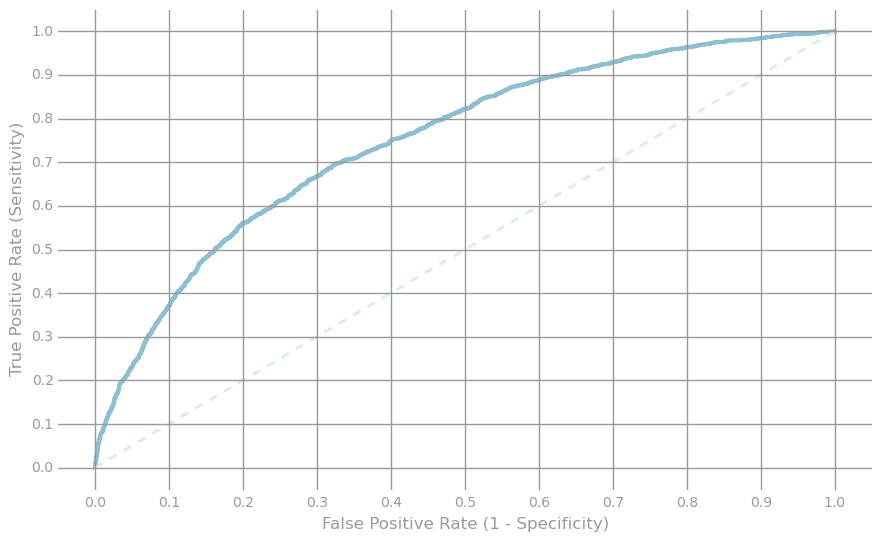

In [52]:
labelsAndScores = OHEValidationData.map(lambda lp:
                                            (lp.label, getP(lp.features, model0.weights, model0.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model
pass

## **Sec. 5: Reduce feature dimension via feature hashing**

### ** Sec. 5.1: Hash function **
As we just saw, using a one-hot-encoding featurization can yield a model with good statistical accuracy.  However, the number of distinct categories across all features is quite large -- recall that we observed 233K categories in the training data in Sec. 3.3.  Moreover, the full Kaggle training dataset includes more than 33M distinct categories, and the Kaggle dataset itself is just a small subset of Criteo's labeled data.  Hence, featurizing via a one-hot-encoding representation would lead to a very large feature vector. To reduce the dimensionality of the feature space, we will use feature hashing.

Below is the hash function that we will use for this part of the lab.  We will first use this hash function with the three sample data points from Sec. 1 to gain some intuition.  Specifically, run code to hash the three sample points using two different values for `numBuckets` and observe the resulting hashed feature dictionaries.

In [92]:
from collections import defaultdict
import hashlib

def hashFunction(numBuckets, rawFeats, printMapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.
    Note:
        Use printMapping=True for debug purposes and to better understand how the hashing works.
    Args:
        numBuckets (int): Number of buckets to use as features.
        rawFeats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        printMapping (bool, optional): If true, the mappings of featureString to index will be
            printed.
    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)
    if(printMapping): print mapping
    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    return dict(sparseFeatures)

#### **(5.1a) Hash feature for the toy example**
Reminder of the sample values:
+ sampleOne = [(0, 'mouse'), (1, 'black')]
+ sampleTwo = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
+ sampleThree =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]

and we have the OHE feature dictionary as

In [115]:
print sampleOHEDictManual

{(2, 'mouse'): 5, (0, 'cat'): 1, (0, 'bear'): 0, (2, 'salmon'): 6, (1, 'tabby'): 4, (1, 'black'): 3, (0, 'mouse'): 2}


Using the hash function to construct the feature, we will have

In [95]:
# Use four buckets
sampOneFourBuckets = hashFunction(4, sampleOne, True)
sampTwoFourBuckets = hashFunction(4, sampleTwo, True)
sampThreeFourBuckets = hashFunction(4, sampleThree, True)
print 
# Use one hundred buckets
sampOneHundredBuckets = hashFunction(100, sampleOne, True)
sampTwoHundredBuckets = hashFunction(100, sampleTwo, True)
sampThreeHundredBuckets = hashFunction(100, sampleThree, True)
print
print '\t\t 4 Buckets \t\t\t 100 Buckets'
print 'SampleOne:\t {0}\t\t {1}'.format(sampOneFourBuckets, sampOneHundredBuckets)
print 'SampleTwo:\t {0}\t\t {1}'.format(sampTwoFourBuckets, sampTwoHundredBuckets)
print 'SampleThree:\t {0}\t {1}'.format(sampThreeFourBuckets, sampThreeHundredBuckets)

{'black1': 2, 'mouse0': 3}
{'cat0': 0, 'tabby1': 0, 'mouse2': 2}
{'bear0': 0, 'black1': 2, 'salmon2': 1}

{'black1': 14, 'mouse0': 31}
{'cat0': 40, 'tabby1': 16, 'mouse2': 62}
{'bear0': 72, 'black1': 14, 'salmon2': 5}

		 4 Buckets 			 100 Buckets
SampleOne:	 {2: 1.0, 3: 1.0}		 {14: 1.0, 31: 1.0}
SampleTwo:	 {0: 2.0, 2: 1.0}		 {40: 1.0, 16: 1.0, 62: 1.0}
SampleThree:	 {0: 1.0, 1: 1.0, 2: 1.0}	 {72: 1.0, 5: 1.0, 14: 1.0}


#### ** (5.1b) Creating hashed features **
Next we will use this hash function to create hashed features for our CTR datasets. First write a function that uses the hash function from Sec. 5.1 with numBuckets = $ \scriptsize 2^{15} \approx 33K $ to create a `LabeledPoint` with hashed features stored as a `SparseVector`.  Then use this function to create new training, validation and test datasets with hashed features. The `parsedHashPoint` function is similar to `parseOHEPoint` from Sec. 3.4.

In [97]:
def parseHashPoint(point, numBuckets):
    """Create a LabeledPoint for this observation using hashing.
    Args:
        point (str): A comma separated string where the first value is the label and the rest are
            features.
        numBuckets: The number of buckets to hash to.
    Returns:
        LabeledPoint: A LabeledPoint with a label (0.0 or 1.0) and a SparseVector of hashed
            features.
    """
    point = point.split(',')
    label = point[0]
    features = [(i, point) for i, point in enumerate(point[1:])]
    hashTable = hashFunction(numBuckets, features, True)
    positionIndex = []
    value = []      ## note now value is no longer just [1,1,1..] since in the hash table
                    ## there will be some conflcut, so sometimes it is 2,3.. i.e. [1,1,2,1,3,..]
    for ch in hashTable:
        positionIndex.append(ch)
        value.append(hashTable[ch])
    v = sorted(range(len(positionIndex)), key=lambda k: positionIndex[k])
    sorted_value = [value[i] for i in v]
    return LabeledPoint(label, SparseVector(numBuckets, sorted(positionIndex), sorted_value))

In [98]:
numBucketsCTR = 2 ** 15
hashTrainData = rawTrainData.map(lambda x: parseHashPoint(x, numBucketsCTR))
hashTrainData.cache()
hashValidationData = rawValidationData.map(lambda x: parseHashPoint(x, numBucketsCTR))
hashValidationData.cache()
hashTestData = rawTestData.map(lambda x: parseHashPoint(x, numBucketsCTR))
hashTestData.cache()

print hashTrainData.take(1)

[LabeledPoint(0.0, (32768,[1305,2883,3807,4814,4866,4913,6952,7117,9985,10316,11512,11722,12365,13893,14735,15816,16198,17761,19274,21604,22256,22563,22785,24855,25202,25533,25721,26487,26656,27668,28211,29152,29402,29873,30039,31484,32493,32708],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


### ** Sec. 5.2: Sparsity **
Since we have 33K hashed features versus 233K OHE features, we should expect OHE features to be sparser. Verify this hypothesis by computing the average sparsity of the OHE and the hashed training datasets.

Note that if you have a `SparseVector` named `sparse`, calling `len(sparse)` returns the total number of features, not the number features with entries.  `SparseVector` objects have the attributes `indices` and `values` that contain information about which features are nonzero.  Continuing with our example, these can be accessed using `sparse.indices` and `sparse.values`, respectively.

To compare, we can first see the indices of hash function feature:

In [128]:
print hashTrainData.take(1)[0].features.indices

[ 1305  2883  3807  4814  4866  4913  6952  7117  9985 10316 11512 11722
 12365 13893 14735 15816 16198 17761 19274 21604 22256 22563 22785 24855
 25202 25533 25721 26487 26656 27668 28211 29152 29402 29873 30039 31484
 32493 32708]


and the indices of the OHE feature:

In [129]:
print OHETrainData.take(1)[0].features.indices

[   382   3101   6842   8311   8911  11887  12893  16211  17631  18646
  23513  29366  33157  39536  55820  61797  81485  82753  93671  96986
 109720 110662 112139 120263 128571 132400 132805 140595 160666 185457
 190322 191105 195902 202638 204242 206037 222753 225966 229941]


From the sample comparison, we can see using hash function, we can even reduce the feature dimension. In the followings, we compute the sparsity, and compare these feature representations:

In [100]:
from operator import add
def computeSparsity(data, d, n):
    """Calculates the average sparsity for the features in an RDD of LabeledPoints.
    Args:
        data (RDD of LabeledPoint): The LabeledPoints to use in the sparsity calculation.
        d (int): The total number of features.
        n (int): The number of observations in the RDD.
    Returns:
        float: The average of the ratio of features in a point to total features.
    """
    '''or return data.map(lambda x: len(x.features.indices)).reduce(add)/float(n)/float(d) '''
    return data.map(lambda x: len(x.features.indices)).sum()/float(n)/float(d)

In [101]:
averageSparsityHash = computeSparsity(hashTrainData, numBucketsCTR, nTrain)
averageSparsityOHE = computeSparsity(OHETrainData, numCtrOHEFeats, nTrain)

print 'Average OHE Sparsity: {0:.7e}'.format(averageSparsityOHE)
print 'Average Hash Sparsity: {0:.7e}'.format(averageSparsityHash)

Average OHE Sparsity: 1.6717677e-04
Average Hash Sparsity: 1.1805561e-03


### ** Sec. 5.3: Logistic model with hashed features **
Now let's train a logistic regression model using the hashed features. Run a grid search to find suitable hyperparameters for the hashed features, evaluating via log loss on the validation data. Note: This may take a few minutes to run. Use `1` and `10` for `stepSizes` and `1e-6` and `1e-3` for `regParams`.

In [45]:
numIters = 500
regType = 'l2'
includeIntercept = True

# Initialize variables using values from initial model training
bestModel = None
bestLogLoss = 1e10

In [46]:
# TODO: Replace <FILL IN> with appropriate code
stepSizes = [1,10]
regParams = [1e-6, 1e-3]
for stepSize in stepSizes:
    for regParam in regParams: 
        model = (LogisticRegressionWithSGD
                 .train(hashTrainData, numIters, stepSize, regParam=regParam, regType=regType,
                        intercept=includeIntercept))
        logLossVa = evaluateResults(model, hashValidationData)
        print ('\tstepSize = {0:.1f}, regParam = {1:.0e}: logloss = {2:.3f}'
               .format(stepSize, regParam, logLossVa))
        if (logLossVa < bestLogLoss):
            bestModel = model
            bestLogLoss = logLossVa

print ('Hashed Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossValBase, bestLogLoss))

	stepSize = 1.0, regParam = 1e-06: logloss = 0.470
	stepSize = 1.0, regParam = 1e-03: logloss = 0.470
	stepSize = 10.0, regParam = 1e-06: logloss = 0.448
	stepSize = 10.0, regParam = 1e-03: logloss = 0.450
Hashed Features Validation Logloss:
	Baseline = 0.527
	LogReg = 0.448


The best perform is to use stepSize = 10 and regParam = 1e-6.

### ** Sec. 5.4: Evaluate on the test set **
Finally, evaluate the best model from Sec. 5.4 on the test set.  Compare the resulting log loss with the baseline log loss on the test set, which can be computed in the same way that the validation log loss was computed in Sec. 4.6.

In [108]:
bestModel = (LogisticRegressionWithSGD
                 .train(hashTrainData, iterations=500, step=10, regParam=1e-6, regType='l2',
                        intercept=True))

In [109]:
# Log loss for the best model from Sec. 5.4:
logLossTest = evaluateResults(bestModel, hashTestData)

# Log loss for the baseline model:
classOneFracTest = hashTestData.filter(lambda x: x.label==1).count()/float(hashTestData.count())
logLossTestBaseline = hashTestData.map(lambda x: computeLogLoss(classOneFracTest, x.label)).mean()

print ('Hashed Features Test Log Loss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossTestBaseline, logLossTest))

Hashed Features Test Log Loss:
	Baseline = 0.537
	LogReg = 0.456


### **Sec. 5.5: Performance comparison using OHE and Hash feature reps**
We can see using hash function to represent features gives slightly better performance than using OHE features (could be subject to some numeric errors). The reason may be less fetaures, the gradient descent is more efficient. But roughly speaking, they are similar.

#### **(5.5a) Validation data**
+ reg     |   logloss(OHE)  |  logloss(hash)
+ 1e-06   |  0.456956712744 |   0.448

#### **(5.5b) Test data**
+ reg     |   logloss(OHE)  |  logloss(hash)
+ 1e-06   |  0.464431773688 |   0.456

## **Sec. 6: Other Classifiers**

### **Sec. 6.1: Naive Bayes Classifier**

The MLlib also has [Naive Bayes](http://spark.apache.org/docs/latest/mllib-naive-bayes.html) classifier. Here we focus on using the hash feature data. First we train the model:

In [59]:
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
nb = NaiveBayes.train(hashTrainData, 1.0)

Note that Naive Bayes classifier is not determined by decreasing loss function. So we cannot compute the logloss for the NB model. Instead, we compute the accuracy how many observations we predicted the same outcome as the label on validation and test datasets.

#### **(6.1a) Accuracy for Naive Bayes**

In [67]:
# Make prediction and test accuracy for Naive Bayes classifier.
predictionAndLabel = hashValidationData.map(lambda p: (nb.predict(p.features), p.label))
print 1.0 * predictionAndLabel.filter(lambda (x, v): x == v).count() / nVal

predictionAndLabel = hashTestData.map(lambda p: (nb.predict(p.features), p.label))
print 1.0 * predictionAndLabel.filter(lambda (x, v): x == v).count() / nTest

0.717518610422
0.719093269423


#### **(6.1b) Accuracy for logistic regression**

In [111]:
# Make prediction and test accuracy for logistic reg classifier.
predictionAndLabel = hashValidationData.map(lambda p: (bestModel.predict(p.features), p.label))
print 1.0 * predictionAndLabel.filter(lambda (x, v): x == v).count() / nVal

predictionAndLabel = hashTestData.map(lambda p: (bestModel.predict(p.features), p.label))
print 1.0 * predictionAndLabel.filter(lambda (x, v): x == v).count() / nTest

0.794441687345
0.795985620132


Here we can slight have a conclusion: **Logistic Regression has better accuracy than Naive Bayes!!!**

### **Sec. 6.2: Decision Trees model (not working)**

The [decision tree model](http://spark.apache.org/docs/latest/mllib-naive-bayes.html) does not work here. The reason could be too many features in the dataset.

In [112]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
DT = DecisionTree.trainClassifier(hashTrainData, 2, {})